In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg

In [2]:
def get_data(filepath):
    weights, costs = [], []
    with open(filepath) as file:
        weight = int(file.readline())

        for line in file.readlines():
            w, c = map(int, line.split())
            weights.append(w)
            costs.append(c)

    return weight, np.array(weights), np.array(costs)

In [3]:
class SAO:
    def __init__(self, num_dims):
        self.solution = np.random.randint(0, 2, size=(num_dims,))

    def main_loop(self, num_iter, threshold_weight, weights, costs, decay_function=lambda x: x, *, verbose=True):
        t = 0
        best_res = -np.inf
        best_solution = np.copy(self.solution)

        prev_fitness = -np.inf
        for i in range(1, num_iter + 1):
            # Generating new solution
            new_solution = np.copy(self.solution)
            ind = np.random.randint(0, self.solution.shape[0])
            new_solution[ind] = 1 - new_solution[ind]

            # Computing fitness
            weight = sum(new_solution * weights)
            fitness = sum(new_solution * costs) if weight <= threshold_weight else -np.inf

            delta_E = fitness - prev_fitness

            # Updating the result
            if delta_E >= 0 or np.random.rand() < np.exp(delta_E / i):
                self.solution = np.copy(new_solution)

            # Updating the best solution so far
            if fitness > best_res:
                best_res = np.copy(fitness)
                best_solution = np.copy(new_solution)

            t = decay_function(i)

            if verbose:
                print("Iteration: %i\nBest cost: %s\nBest solution: %s" % (i, best_res, best_solution))

        return best_res, best_solution

In [168]:
weight, weights, costs = get_data(r"Datasets\Data50.txt")
test = SAO(len(weights))
res, sol = test.main_loop(10_000, weight, weights, costs, decay_function=lambda x: np.exp(-x/10 ** 3), verbose=False)
print(f"The answer should have weight not bigger than {weight}. Answer weight is", sum(weights * sol))
print(res)

The answer should have weight not bigger than 1989. Answer weight is 1985
3067


In [29]:
class GO:
    def __init__(self, num_pop, num_dims):
        self.num_pop = num_pop
        self.population = np.random.randint(0, 2, size=(num_pop, num_dims))
 
    @np.vectorize(excluded=['population', "mutation_chance", "result"])
    def crossover(num_child, population, result, mutation_chance=0.3):
        n = len(population)
        p1, p2 = np.random.randint(0, n), np.random.randint(0, n)

        while p1 == p2:
            p1 = np.random.randint(0, n)

        # Creating empty children variables
        child1, child2 = np.zeros_like(population[p1]), np.zeros_like(population[p1])

        # Deciding on crossover point
        crossover_point = np.random.randint(0, population.shape[1])

        # Generating the first child
        child1[:crossover_point] = population[p1][:crossover_point]
        child1[crossover_point:] = population[p2][crossover_point:]

        # Generating the second child
        child1[:crossover_point] = population[p2][:crossover_point]
        child1[crossover_point:] = population[p1][crossover_point:]

        # Performing mutation on the first child
        if np.random.rand() < mutation_chance:
            ind = np.random.randint(0, child1.shape[0])
            child1[ind] = 1 - child1[ind]

        # Updating the population
        result.extend([child1, child2])

    def main_loop(self, num_iter, num_child, mutation_chance, threshold_weight, weights, costs, *, gif_name="GO", verbose=True, plot=True):
        # Function to compute fitness
        def fitness(agent):
            cost = sum(agent * costs)
            weight = sum(agent * weights)
            return cost if weight <= threshold_weight else -np.inf
        
        convergence = []

        # plotting
        fig, ax = plt.subplots()
        images = []
        canvas = FigureCanvasAgg(fig)
        
        dummy = np.zeros(shape=(num_child,1)) # dummy variable to vectorize crossover

        best_res = -np.inf
        best_solution = np.zeros_like(self.population[0])

        for i in range(num_iter):
            # Variable to store children after crossover
            children = []
            self.crossover(num_child=dummy, population=self.population, result=children, mutation_chance=mutation_chance)
            self.population = np.append(self.population, children, axis=0)

            fitness_arr = np.apply_along_axis(fitness, 1, self.population)
            sorted_indices = np.argsort(-fitness_arr) # Multiplying by -1 so that sorted array will be in decrasing order

            # Removing bad individuals from population
            self.population = self.population[sorted_indices][:self.num_pop]
            fitness_arr = fitness_arr[sorted_indices][:self.num_pop]

            max_ind = fitness_arr.argmax()
            
            if fitness_arr[max_ind] > best_res:
                best_res = np.copy(fitness_arr[max_ind])
                best_solution = np.copy(self.population[max_ind])

            convergence.append(best_res)

            if i % 10 == 0:
                plt.title(f"Genetic Algorithm on iteration {i}")
                ax.hist(fitness_arr)

                # Render the plot as an RGBA buffer
                canvas.draw()
                buf = canvas.buffer_rgba()

                # Create a PIL Image from the RGBA buffer
                image = Image.frombytes('RGBA', canvas.get_width_height(), buf, 'raw', 'RGBA')
                images.append(image)
                plt.cla()

            if verbose:
                print("Iteration: %i\nBest cost: %s\nBest solution: %s" % (i, best_res, best_solution))

        # something like pause    
        images.extend([images[-1]] * max(100, num_iter // 25 + 1))

        images[0].save(f'{gif_name}.gif',
            save_all=True, append_images=images[1:], optimize=False, duration=10, loop=0)
        
        if plot:
            plt.plot(range(num_iter), convergence)

        return best_res, best_solution

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:402: RuntimeWarning: invalid value encountered in cast
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


The answer should have weight not bigger than 1989. Answer weight is 1983
3324.0


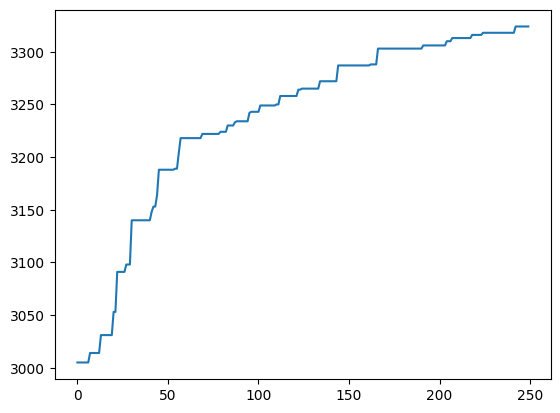

In [30]:
weight, weights, costs = get_data(r"Datasets\Data50.txt")
test2 = GO(100, len(weights))
res, sol = test2.main_loop(250, 50, 0.3, weight, weights, costs, verbose=False)
print(f"The answer should have weight not bigger than {weight}. Answer weight is", sum(weights * sol))
print(res)